# Loading Dataset

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from project_fraud.lib import merge_data
df = merge_data()
df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
len(np.unique(df['card1']))

17091

In [5]:
df.shape

(1097231, 433)

In [6]:
# avg. amount of transactions per card

df.shape[0] / len(np.unique(df['card1']))

64.19934468433678

In [10]:
df['card1']

0          13926
1           2755
2           4663
3          18132
4           4497
           ...  
1097226    13832
1097227     3154
1097228    16661
1097229    16621
1097230     5713
Name: card1, Length: 1097231, dtype: int64

# Modeling

In [29]:
from sklearn import preprocessing
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [11]:
df_num = df.select_dtypes(include=['float64', 'int64'])

In [8]:
# creating target and feature variables 

y_train = df['isFraud']

# select feature by type
X_train = df_num.drop('isFraud', axis=1)

KeyError: 'isFraud'

In [34]:
y_train.unique()

array([0, 1], dtype=int64)

## Create smaller dataset for investigation 

In [35]:
# Create a smaller dataset for investigation purpose only
sample_size = 20000

X_small = X_train.sample(sample_size, random_state=0)
y_small = y_train.sample(sample_size, random_state=0)

## Simple Model (first iteration)

In [36]:
# create Basemodel: SGDClassifier Logistic Regression 

base_model = SGDClassifier(loss='log', alpha=0.5, class_weight='balanced')
cv_results_base_model = cross_validate(base_model, X_small, y_small, cv=5, n_jobs=1, scoring=['recall', 'f1_macro'])
cv_results_base_model['test_f1_macro'].mean()

nan

In [41]:
# Logistic Regression Model 

log_model = LogisticRegression(class_weight='balanced')
cv_results_log_model = cross_val_score(log_model, X_small, y_small, cv=5, scoring='recall')
cv_results_log_model

array([nan, nan, nan, nan, nan])

## Feature Permutation 

In [ ]:
# Base Model 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define X and y
X = train_df.drop('isFraud')
y = train_df['isFraud']

# split dataset 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=2)

log_model = LogisticRegression()

log_model.fit(X_train,y_train)

log_model.score(X_test,y_test)


# Permutation 

from sklearn.inspection import permutation_importance

permutation_score = permutation_importance(log_model, X_train, y_train, n_repeats=100)

np.vstack((X.columns, permutation_score.importances_mean)).T

## Feature Engineering 

### New feature: day of the week 

In [16]:
# create new feature day of the week, encoded as 0-6 
# found a good offset is 0.58

def make_day_feature(df, offset=0, column_name='TransactionDT'):

    days = df[column_name] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

### New feature: hour of the day

In [12]:
# create new feature hour of the day, encoded as 0-23

def make_hour_feature(df, column_name='TransactionDT'):

    hours = df[column_name] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

(0.0, 1000.0)

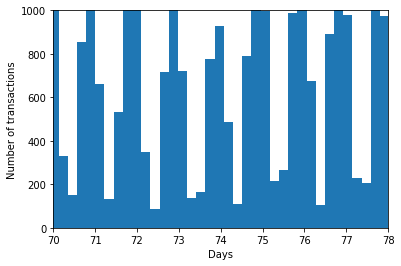

In [13]:
# visualize periodicity: number of transactions per time interval 

vals = plt.hist(df['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,1000)

### Create new features

In [17]:
# create new feature weekday
# offset to define start of the day: 0.85

df['weekday'] = make_day_feature(df, offset=0.58)

plt.plot(df.groupby('weekday').mean()['isFraud'])

plt.ylim(0, 0.04)
plt.xlabel('Encoded day')
plt.ylabel('Fraction of fraudulent transactions')

# outputs fraction of fraudulent transactions per weekday 

KeyError: 'isFraud'

In [ ]:
# create a feature which encodes the (relative) hour of the day

train_df['hours'] = make_hour_feature(train_df)

plt.plot(train.groupby('hours').mean()['isFraud'], color='k')

ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

## New features on each credit card

In [18]:
duplicateRowsDF = df[df.duplicated(['card1', 'card2', 'card3', 'card4', 'card5', 'card6'])]

In [22]:
df.shape

(1097231, 434)

In [21]:
duplicateRowsDF.shape

(1077920, 434)

In [54]:
df[(df.card4 == 'visa')]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday
2,2987002,86469,59.000,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,2987005,86510,49.000,W,5937,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,2987006,86522,159.000,W,12308,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,2987007,86529,422.500,W,12695,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,2987008,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097219,4170228,34214214,82.383,C,2275,555.0,119.0,visa,137.0,credit,...,NaN,NaN,NaN,F,F,T,F,mobile,Moto G (5) Plus,3.0
1097223,4170232,34214269,67.950,W,12544,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1097225,4170234,34214277,50.000,H,9002,453.0,150.0,visa,226.0,debit,...,32.0,1334x750,match_status:2,T,F,F,T,mobile,iOS Device,3.0
1097228,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [55]:
df[(df.card4 == 'visa')].card5.unique()

array([166., 226., 195., 138., 100., 147., 162., 137., 183., 228., 126.,
       102., 144.,  nan, 141., 169., 177., 194., 180., 200., 184., 167.,
       113., 223., 196., 165., 125., 189., 205., 191., 209., 175., 192.,
       155., 161., 153., 124., 193.])

In [57]:
df[(df.card4 == 'mastercard')].card5.unique()

array([102., 117., 224., 134., 219., 166., 202., 195., 171., 197., 137.,
       149., 229.,  nan, 182., 190., 100., 126., 223., 203., 140., 129.,
       111., 141., 156., 135., 107., 232., 177., 127., 139., 210., 204.,
       212., 152., 222., 214., 189., 225., 159., 121., 217., 211., 123.,
       172., 114., 221., 234., 130., 109., 101., 158., 230., 191., 115.,
       233., 216., 226., 194., 178., 163., 112., 168., 235., 220., 176.,
       208., 138., 218., 186., 183., 227., 125., 174.])

In [58]:
visa_card5 = Out[55]

In [59]:
mastercard_card5 = Out[57]

In [61]:
len(visa_card5)

38

In [62]:
len(mastercard_card5)

74

In [63]:
card5_unique = Out[52]

In [64]:
len(card5_unique)

139

In [52]:
df['card4'].card5.unique()

array([142., 102., 166., 117., 226., 224., 134., 219., 137., 195., 138.,
       100., 147., 162., 202., 118., 150., 183., 171., 236., 197., 133.,
       223., 149., 228., 229.,  nan, 198., 182., 126., 185., 190., 131.,
       144., 141., 215., 203., 237., 132., 143., 146., 140., 129., 199.,
       194., 213., 111., 169., 177., 173., 156., 119., 135., 107., 232.,
       188., 159., 127., 148., 139., 104., 210., 180., 207., 204., 212.,
       106., 152., 222., 187., 200., 214., 189., 181., 206., 225., 157.,
       121., 217., 184., 167., 113., 136., 120., 201., 211., 122., 164.,
       123., 145., 172., 114., 231., 105., 221., 234., 130., 109., 196.,
       101., 158., 230., 128., 191., 165., 115., 233., 216., 116., 178.,
       125., 163., 205., 112., 168., 209., 235., 151., 175., 160., 220.,
       103., 176., 192., 208., 154., 218., 170., 186., 108., 227., 155.,
       161., 153., 124., 179., 193., 174., 110.])

In [27]:
duplicateRowsDF.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday
18,2987018,86725,47.95,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
51,2987051,87328,226.00,W,7835,361.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
57,2987057,87445,50.00,H,11839,490.0,150.0,visa,226.0,debit,...,32.0,1920x1080,match_status:2,T,F,T,T,mobile,SM-G930V Build/NRD90M,0.0
61,2987061,87596,58.95,W,12544,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
62,2987062,87601,200.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [30]:
df.duplicated(subset=['card1', 'card2', 'card3', 'card4', 'card5', 'card6'], keep=False).head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [32]:
df.iloc[0]

TransactionID     2987000
TransactionDT       86400
TransactionAmt       68.5
ProductCD               W
card1               13926
                   ...   
id_37                 NaN
id_38                 NaN
DeviceType            NaN
DeviceInfo            NaN
weekday                 0
Name: 0, Length: 434, dtype: object

In [38]:
df.loc[(df['card1'] == 4663) & (df['card2'] == 490.0)].shape

(1787, 434)

In [40]:
df.loc[(df['card1'] == 4663)].shape

(1794, 434)

In [51]:
df_card = df.loc[(df['card1'] == 4663) & (df['card2'] == 490.0) & (df['card3'] == 150.0) & (df['card4'] == 'visa') & (df['card5'] == 166.0) & (df['card6'] == 'debit')]

In [45]:
df_card['TransactionAmt'].mean()

104.82782876329044

In [46]:
df_card.TransactionAmt.max()

1386.0

In [65]:
# write function that creates new df for individual creadit cards 

def card(df, card1, card2, card3, card4, card5, card6): 
    df_card = df.loc[(df['card1'] == card1) & (df['card2'] == card2) & (df['card3'] == card3) & (df['card4'] == card4) & (df['card5'] == card5) & (df['card6'] == card6)]
    
    return df_card

In [67]:
card(df, 4663, 490.0, 150.0, 'visa', 166.0, 'debit')

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday
2,2987002,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
18,2987018,86725,47.95,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1255,2988255,129300,221.99,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1350,2988350,131823,48.95,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1500,2988500,134534,40.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093096,4166105,34101316,57.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1093764,4166773,34111557,117.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1094070,4167079,34116497,77.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1096156,4169165,34193926,649.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [71]:
df['card2'].isna().sum()

17587

In [73]:
# convert float to int 

df['card2'] = df['card2'].astype(str)
df['card3'] = df['card3'].astype(str)
df['card5'] = df['card5'].astype(str)

MemoryError: Unable to allocate 3.26 GiB for an array with shape (399, 1097231) and data type float64

In [72]:
# create new column whith combined card details 
df['cardID'] = df['card1'] + df['card2'] + df['card3'] + df['card4'] + df['card5'] + df['card6']

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:
# groupby 
credit_cards = df.groupby('cardID')

# apply 
credit_cards[['TransactionAmt']].mean()
credit_cards[['TransactionAmt']].min()
credit_cards[['TransactionAmt']].max()
credit_cards[['TransactionAmt']].median()

In [ ]:
# new feature
df['dist_mean'] = df['TransactionAmt'] - credit_cards[['TransactionAmt']].mean()

In [ ]:
# https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/#:~:text=To%20find%20%26%20select%20the%20duplicate,argument%20is%20'first').
# Select all duplicate rows based on multiple column names in list
# duplicateRowsDF = dfObj[dfObj.duplicated(['Age', 'City'])]


## Advanced Models 

In [ ]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Simple Decision Tree 

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight='balanced')
cv_result_dt_model = cross_val_score(dt_model, X_train, y_train, cv=3, scoring=['recall', 'f1_macro'])

### Random Forest Classifier 

In [ ]:
# Simple Random Forest 

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(class_weight='balanced', random_state=0)
cv_results_forest = cross_validate(forest, X_train, y_train, cv=5, scoring='f1_macro')
print(cv_results_forest['test_score'].mean())

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
# Do we overfit on our train set?
f1_score(forest.predict(X_train_small), y_train_small, average='macro')

In [ ]:
print(classification_report(forest.predict(X_test_small), y_test_small))

Hyperparameter Tuning 

In [ ]:
# Wide RandomSearch

model = RandomForestClassifier(class_weight='balanced')

search_space = {'n_estimators': [int(x) for x in np.linspace(50, 1000, num=20)],
                'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'criterion': ['gini'],
                'bootstrap': [True, False]
                }

cv_model = RandomizedSearchCV(model,
                              scoring='f1_macro',
                              param_distributions=search_space,
                              n_jobs=-1,
                              cv=3,
                              n_iter=30,
                              verbose=1)

search = cv_model.fit(X_train_small, y_train_small)

In [ ]:
search.best_score_

In [ ]:
search.best_params_

In [ ]:
best_forest = RandomForestClassifier(**{'n_estimators': 300, 'max_depth': 15, 'bootstrap': False})
cross_validate(best_forest, X_train_small, y_train_small, cv=5, scoring='f1_macro')['test_score'].mean()

In [ ]:
# Final Evaluation!
print(classification_report(best_forest.fit(X_train_small, y_train_small).predict(X_test_small), y_test_small))

### Naive Bayes